In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV
import warnings
from tabulate import tabulate

In [2]:
current_dir = os.getcwd() 
relative_path = os.path.join('..', '..','data', 'train.csv')
train_data = pd.read_csv(os.path.join(current_dir, relative_path))

In [3]:
relative_path = os.path.join('..', '..','data', 'test.csv')
test_data = pd.read_csv(os.path.join(current_dir, relative_path))

In [4]:
relative_path = os.path.join('..', '..','data', 'dataset.csv')
data = pd.read_csv(os.path.join(current_dir, relative_path))

In [5]:
x_train = train_data.drop(["Attrition"], axis = 1)
y_train = train_data["Attrition"]

x_test = test_data.drop(["Attrition"], axis = 1)
y_test = test_data["Attrition"]

x = data.drop(["Attrition"], axis = 1)
y = data["Attrition"]

k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

In [6]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

{'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l1'}


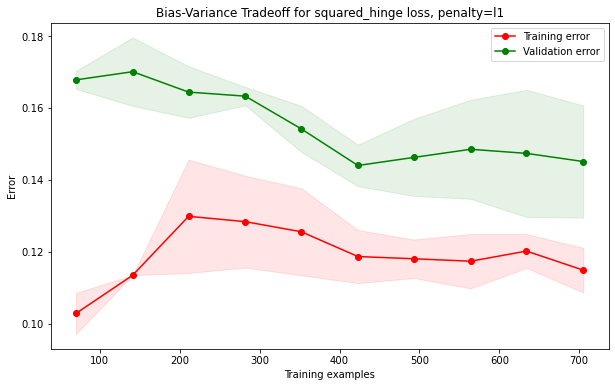

{'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}
{'C': 1, 'loss': 'squared_hinge', 'penalty': 'l1'}
{'C': 1, 'loss': 'squared_hinge', 'penalty': 'l2'}
{'C': 10, 'loss': 'squared_hinge', 'penalty': 'l1'}
{'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2'}
{'C': 100, 'loss': 'squared_hinge', 'penalty': 'l1'}
{'C': 100, 'loss': 'squared_hinge', 'penalty': 'l2'}
| Parameters                                           |   Accuracy |   Precision |   Recall |   F1 Score |   Support |   Macro Precision |   Macro Recall |   Macro F1 Score |   Train Score |   Val Score |
|------------------------------------------------------|------------|-------------|----------|------------|-----------|-------------------|----------------|------------------|---------------|-------------|
| {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l1'} |   0.863946 |    0.832704 | 0.863946 |   0.840034 |       294 |          0.679337 |       0.584917 |         0.605263 |      0.885488 |    0.870748 |
| {'C': 0.1, 'los

In [11]:
import warnings
from sklearn.model_selection import ParameterGrid, train_test_split, learning_curve
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'loss': [ 'squared_hinge'],
    'penalty': ['l1', 'l2']
}

# Define variables to store the best metrics
best_accuracy = 0
best_params = None
best_report = None
best_train_scores = None
best_val_scores = None

# Table rows
rows = []

# Track unique kernel types
unique_kernels = set()

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):

    print(params)

    # Create the LinearSVC model
    svm = LinearSVC(**params, dual=False)

    # Train the model
    svm.fit(X_train_encoded, y_train)

    # Calculate training and validation scores
    train_sizes, train_scores, val_scores = learning_curve(svm, X_train_encoded, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and standard deviation for each training size
    train_mean = 1 - np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = 1 - np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the bias-variance tradeoff only once for each kernel type
    if params['loss'] not in unique_kernels:
        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training error")
        plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation error")
        plt.xlabel("Training examples")
        plt.ylabel("Error")
        plt.title(f"Bias-Variance Tradeoff for {params['loss']} loss, penalty={params['penalty']}")
        plt.legend(loc="best")
        plt.show()

        # Add the kernel type to the set
        unique_kernels.add(params['loss'])

    # Make predictions
    y_pred = svm.predict(X_test_encoded)

    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the best parameters
    if report['accuracy'] > best_accuracy:
        best_accuracy = report['accuracy']
        best_params = params
        best_report = report
        best_train_scores = svm.score(X_train_encoded, y_train)
        best_val_scores = svm.score(X_val_encoded, y_val)

    # Append the row
    rows.append([params, report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score'],
                 report['weighted avg']['support'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'],
                 svm.score(X_train_encoded, y_train), svm.score(X_val_encoded, y_val)])

# Table headers with added Training and Validation Scores
headers = ["Parameters", "Accuracy", "Precision", "Recall", "F1 Score", "Support", "Macro Precision", "Macro Recall", "Macro F1 Score",
           "Train Score", "Val Score"]

# Print the table
print(tabulate(rows, headers=headers, tablefmt='github'))

# Print the best parameters and the report for the best accuracy
print("________________________________________________")
print("Best Parameters:", best_params)
print("\nClassification Report for Best Accuracy:")
report_df = pd.DataFrame(best_report).transpose()
print(tabulate(report_df, headers='keys', tablefmt='github'))

# Print the training and validation scores for the best model
print("\nBest Model Training Scores:", best_train_scores)
print("Best Model Validation Scores:", best_val_scores)
